In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

Set random seed for reproducibility


In [2]:
torch.manual_seed(42)
np.random.seed(42)

Device configuration


In [3]:
device = "cuda"
print(f"Using device: {device}")

Using device: cuda


In [4]:
seq_len = 12

Load and prepare data


Create a unique location identifier and time key


In [5]:
data = pd.read_csv("rnn_data_train.csv")
data.columns

Index(['location_id', 'Year', 'Month', 'crime_count', 'weekday', 'weekend',
       'morning', 'afternoon', 'evening', 'night', 'holiday_num', 'num_days',
       'morning_rate', 'afternoon_rate', 'evening_rate', 'night_rate',
       'sin_month', 'cos_month', 'time_id', 'crime_pct_change'],
      dtype='object')

In [6]:
n_times = data["time_id"].nunique()
n_locations = data["location_id"].nunique()
location2idx = {location: i for i, location in enumerate(data["location_id"].unique())}
time2idx = {time: i for i, time in enumerate(data["time_id"].unique())}
data["location_idx"] = data["location_id"].map(location2idx)
data["time_idx"] = data["time_id"].map(time2idx)
data

,location_id,Year,Month,crime_count,weekday,weekend,morning,afternoon,evening,night,...,morning_rate,afternoon_rate,evening_rate,night_rate,sin_month,cos_month,time_id,crime_pct_change,location_idx,time_idx
0,1,2018,1,20,15,5,8,6,4,2,...,0.400000,0.300000,0.200000,0.100000,0.000000,1.000000e+00,24217,-0.166667,0,0
1,1,2018,2,20,18,2,11,4,2,3,...,0.550000,0.200000,0.100000,0.150000,0.500000,8.660254e-01,24218,0.000000,0,1
2,1,2018,3,24,14,10,10,12,2,0,...,0.416667,0.500000,0.083333,0.000000,0.866025,5.000000e-01,24219,0.200000,0,2
3,1,2018,4,27,17,10,8,16,1,2,...,0.296296,0.592593,0.037037,0.074074,1.000000,6.123234e-17,24220,0.125000,0,3
4,1,2018,5,36,30,6,11,11,10,4,...,0.305556,0.305556,0.277778,0.111111,0.866025,-5.000000e-01,24221,0.333333,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2428,99,2024,8,91,70,21,33,46,8,4,...,0.362637,0.505495,0.087912,0.043956,-0.500000,-8.660254e-01,24296,0.022472,31,79
2429,99,2024,9,59,47,12,24,21,6,8,...,0.406780,0.355932,0.101695,0.135593,-0.866025,-5.000000e-01,24297,-0.351648,31,80
2430,99,2024,10,73,65,8,31,30,5,7,...,0.424658,0.410959,0.068493,0.095890,-1.000000,-1.840000e-16,24298,0.237288,31,81
2431,99,2024,11,56,47,9,26,20,4,6,...,0.464286,0.357143,0.071429,0.107143,-0.866025,5.000000e-01,24299,-0.232877,31,82


In [7]:
features = [
    "crime_count",
    "crime_pct_change",
    "Year",
    "Month",
    "morning_rate",
    "evening_rate",
    "afternoon_rate",
    "night_rate",
    "num_days",
    "holiday_num",
    "sin_month",
    "cos_month",
]
n_features = len(features)
pivot_df = data.pivot(
    index="time_idx",
    columns="location_idx",
    values=features,
)
pivot_df = pivot_df.fillna(0)
train_size = int((len(pivot_df) - seq_len) - 12)
print(f"train_size: {train_size}")
# time_features = pd.DataFrame(index=pivot_df.index)
# time_features["holiday_num"] = data.groupby("time_idx")["holiday_count"].first()
# time_features["sin_month"] = data.groupby("time_idx")["sin_month"].first()
# time_features["cos_month"] = data.groupby("time_idx")["cos_month"].first()
pivot_df

train_size: 60


crime_count                                                      \
location_idx          0      1     2     3     4      5      6     7      8    
time_idx                                                                       
0                   20.0  518.0  18.0  49.0  20.0  115.0  189.0   1.0  143.0   
1                   20.0  504.0  29.0  58.0  16.0  108.0  179.0   1.0  139.0   
2                   24.0  566.0  23.0  33.0  26.0  123.0  228.0   0.0  149.0   
3                   27.0  563.0  26.0  40.0  20.0  118.0  246.0   0.0  170.0   
4                   36.0  628.0  31.0  50.0  41.0  133.0  215.0   0.0  165.0   
...                  ...    ...   ...   ...   ...    ...    ...   ...    ...   
79                  13.0  541.0  34.0   5.0   9.0   83.0  226.0  51.0  339.0   
80                   3.0  503.0  15.0  13.0  16.0   94.0  198.0  42.0  328.0   
81                  15.0  482.0  17.0  12.0  12.0  108.0  209.0  39.0  360.0   
82                  18.0  428.0  17.0  17.0  21.0   87.0  195.0  51.0  291.0   
83                  16.0  431.0  20.0  14.0  13.0   60.0  198.0  24.0  331.0   

                    ...     cos_month                                   \
location_idx    9   ...            22   23            24            25   
time_idx            ...                                                  
0             28.0  ...  0.000000e+00  0.0  1.000000e+00  1.000000e+00   
1             21.0  ...  8.660254e-01  0.0  8.660254e-01  8.660254e-01   
2             27.0  ...  5.000000e-01  0.0  5.000000e-01  5.000000e-01   
3             34.0  ...  6.123234e-17  0.0  6.123234e-17  6.123234e-17   
4             36.0  ... -5.000000e-01  0.0 -5.000000e-01 -5.000000e-01   
...            ...  ...           ...  ...           ...           ...   
79            20.0  ... -8.660254e-01  0.0 -8.660254e-01 -8.660254e-01   
80            15.0  ... -5.000000e-01  0.0 -5.000000e-01 -5.000000e-01   
81            21.0  ... -1.840000e-16  0.0 -1.840000e-16 -1.840000e-16   
82            11.0  ...  0.000000e+00  0.0  5.000000e-01  5.000000e-01   
83            15.0  ...  0.000000e+00  0.0  8.660254e-01  8.660254e-01   

                                                                      \
location_idx            26            27            28            29   
time_idx                                                               
0             1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
1             8.660254e-01  8.660254e-01  8.660254e-01  8.660254e-01   
2             5.000000e-01  5.000000e-01  5.000000e-01  5.000000e-01   
3             6.123234e-17  6.123234e-17  6.123234e-17  6.123234e-17   
4            -5.000000e-01 -5.000000e-01 -5.000000e-01 -5.000000e-01   
...                    ...           ...           ...           ...   
79           -8.660254e-01 -8.660254e-01 -8.660254e-01 -8.660254e-01   
80           -5.000000e-01 -5.000000e-01 -5.000000e-01 -5.000000e-01   
81           -1.840000e-16 -1.840000e-16 -1.840000e-16 -1.840000e-16   
82            5.000000e-01  5.000000e-01  5.000000e-01  5.000000e-01   
83            8.660254e-01  8.660254e-01  8.660254e-01  8.660254e-01   

                                          
location_idx            30            31  
time_idx                                  
0             1.000000e+00  1.000000e+00  
1             8.660254e-01  8.660254e-01  
2             5.000000e-01  5.000000e-01  
3             6.123234e-17  6.123234e-17  
4            -5.000000e-01 -5.000000e-01  
...                    ...           ...  
79           -8.660254e-01 -8.660254e-01  
80           -5.000000e-01 -5.000000e-01  
81           -1.840000e-16 -1.840000e-16  
82            5.000000e-01  5.000000e-01  
83            8.660254e-01  8.660254e-01  

[84 rows x 384 columns]

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaled_df = pivot_df.copy()
scaler = MinMaxScaler()
print(scaled_df.shape)
scaled_df[: train_size + seq_len] = scaler.fit_transform(
    scaled_df[: train_size + seq_len]
)
scaled_df[train_size + seq_len :] = scaler.transform(scaled_df[train_size + seq_len :])
scaled_df = pd.DataFrame(scaled_df, columns=pivot_df.columns)
scaled_df

(84, 384)


crime_count                                                    \
location_idx          0         1         2         3         4         5    
time_idx                                                                     
0               0.542857  0.552102  0.326531  0.836364  0.277778  0.612613   
1               0.542857  0.526508  0.551020  1.000000  0.166667  0.549550   
2               0.657143  0.639854  0.428571  0.545455  0.444444  0.684685   
3               0.742857  0.634369  0.489796  0.672727  0.277778  0.639640   
4               1.000000  0.753199  0.591837  0.854545  0.861111  0.774775   
...                  ...       ...       ...       ...       ...       ...   
79              0.342857  0.594150  0.653061  0.036364 -0.027778  0.324324   
80              0.057143  0.524680  0.265306  0.181818  0.166667  0.423423   
81              0.400000  0.486289  0.306122  0.163636  0.055556  0.549550   
82              0.485714  0.387569  0.306122  0.254545  0.305556  0.360360   
83              0.428571  0.393053  0.367347  0.200000  0.083333  0.117117   

                                                      ... cos_month            \
location_idx        6         7         8         9   ...        22        23   
time_idx                                              ...                       
0             0.546713  0.016667  0.202247  0.619048  ...  0.500000  0.464102   
1             0.512111  0.016667  0.187266  0.452381  ...  0.933013  0.464102   
2             0.681661  0.000000  0.224719  0.595238  ...  0.750000  0.464102   
3             0.743945  0.000000  0.303371  0.761905  ...  0.500000  0.464102   
4             0.636678  0.000000  0.284644  0.809524  ...  0.250000  0.464102   
...                ...       ...       ...       ...  ...       ...       ...   
79            0.674740  0.850000  0.936330  0.428571  ...  0.066987  0.464102   
80            0.577855  0.700000  0.895131  0.309524  ...  0.250000  0.464102   
81            0.615917  0.650000  1.014981  0.452381  ...  0.500000  0.464102   
82            0.567474  0.850000  0.756554  0.214286  ...  0.500000  0.464102   
83            0.577855  0.400000  0.906367  0.309524  ...  0.500000  0.464102   

                                                                          \
location_idx        24        25        26        27        28        29   
time_idx                                                                   
0             1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1             0.933013  0.933013  0.933013  0.933013  0.933013  0.933013   
2             0.750000  0.750000  0.750000  0.750000  0.750000  0.750000   
3             0.500000  0.500000  0.500000  0.500000  0.500000  0.500000   
4             0.250000  0.250000  0.250000  0.250000  0.250000  0.250000   
...                ...       ...       ...       ...       ...       ...   
79            0.066987  0.066987  0.066987  0.066987  0.066987  0.066987   
80            0.250000  0.250000  0.250000  0.250000  0.250000  0.250000   
81            0.500000  0.500000  0.500000  0.500000  0.500000  0.500000   
82            0.750000  0.750000  0.750000  0.750000  0.750000  0.750000   
83            0.933013  0.933013  0.933013  0.933013  0.933013  0.933013   

                                  
location_idx        30        31  
time_idx                          
0             1.000000  1.000000  
1             0.933013  0.933013  
2             0.750000  0.750000  
3             0.500000  0.500000  
4             0.250000  0.250000  
...                ...       ...  
79            0.066987  0.066987  
80            0.250000  0.250000  
81            0.500000  0.500000  
82            0.750000  0.750000  
83            0.933013  0.933013  

[84 rows x 384 columns]

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler


def scale_by_feature_type(pivot_df, train_size, seq_len):
    scaled_df = pivot_df.copy()
    feature_types = pivot_df.columns.get_level_values(0).unique()
    scaler_ls = []
    for feature in feature_types:
        feature_cols = [col for col in pivot_df.columns if col[0] == feature]
        scaler = MinMaxScaler()
        feature_data = pivot_df[feature_cols]
        train_data = feature_data.iloc[: train_size + seq_len]
        scaler.fit(train_data)
        scaled_df[feature_cols] = scaler.transform(feature_data)
        scaler_ls.append(scaler)
    return scaled_df, scaler_ls


scaled_df, scaler_ls = scale_by_feature_type(pivot_df, train_size, seq_len)

In [10]:
import numpy as np
import pandas as pd


def create_sequences(feat_df, seq_length=12):
    X_seq = []
    y_vals = []
    loc_idx = []
    time_idx = []
    T = feat_df.shape[0]
    locations = feat_df.columns.get_level_values(1).unique()
    crime_feature = feat_df.columns.get_level_values(0)[
        0
    ]  # Assuming 'crime_count' is the first feature type
    for location in locations:
        location_data = feat_df.xs(location, axis=1, level=1)

        # Create sliding windows
        for i in range(T - seq_length):
            # Extract feature window for all features
            feature_window = location_data.iloc[
                i : i + seq_length
            ].values  # shape (seq_length, n_features)
            y_val = feat_df[(crime_feature, location)].iloc[i + seq_length]
            X_seq.append(feature_window)
            y_vals.append(y_val)
            loc_idx.append(location)
            time_idx.append(i)
    X_seq = np.array(X_seq)  # shape => (n_locations * n_times, seq_length, n_features)
    y_vals = np.array(y_vals)  # shape => (n_locations * n_times,)
    loc_idx = np.array(loc_idx)  # shape => (n_locations * n_times,)
    time_idx = np.array(time_idx)  # shape => (n_locations * n_times,)
    return X_seq, y_vals, loc_idx, time_idx


seq_length = 12
X_seq, y, loc_idx, time_idx = create_sequences(scaled_df, seq_length=seq_length)

print("X_seq shape:", X_seq.shape)  # (n_locations * n_times, seq_length, n_features)
print("y shape:", y.shape)  # (n_locations * n_times,)
print("loc_idx shape:", loc_idx.shape)  # (n_locations * n_times,)
print("time_idx shape:", time_idx.shape)  # (n_locations * n_times,)

X_seq shape: (2304, 12, 12)
y shape: (2304,)
loc_idx shape: (2304,)
time_idx shape: (2304,)


In [11]:
train_mask = time_idx < train_size
test_mask = time_idx >= train_size

X_train = X_seq[train_mask]
y_train = y[train_mask]
loc_train = loc_idx[train_mask]
time_train = time_idx[train_mask]

X_test = X_seq[test_mask]
y_test = y[test_mask]
loc_test = loc_idx[test_mask]
time_test = time_idx[test_mask]

print("Train shapes:", X_train.shape, y_train.shape, loc_train.shape, time_train.shape)
print("Test shapes:", X_test.shape, y_test.shape, loc_test.shape, time_test.shape)

Train shapes: (1920, 12, 12) (1920,) (1920,) (1920,)
Test shapes: (384, 12, 12) (384,) (384,) (384,)


In [12]:
from torch.utils.data import Dataset, DataLoader


class CrimeDataset(Dataset):
    def __init__(self, X, y, loc_idx, time_idx):
        self.X = X  # n_sequences, seq_len, n_location
        self.y = y  # n_sequences, n_location
        self.loc_idx = loc_idx
        self.time_idx = time_idx

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = torch.tensor(self.X[idx], dtype=torch.float32)
        y = torch.tensor(self.y[idx], dtype=torch.float32)
        loc_idx = torch.tensor(self.loc_idx[idx], dtype=torch.long)
        time_idx = torch.tensor(self.time_idx[idx], dtype=torch.long)
        return X, y, loc_idx, time_idx

In [13]:
num_size = n_features
cat_size = n_locations
batch_size = 32
hidden_size = 128
num_layers = 3
embed_dim = 16
output_size = 1
num_epochs = 100
dropout = 0.5

In [14]:
train_dataset = CrimeDataset(X_train, y_train, loc_train, time_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = CrimeDataset(X_test, y_test, loc_test, time_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [15]:
for X_batch, y_batch, loc_batch, time_batch in train_loader:
    print(f"X_batch shape: {X_batch.shape}")
    print(f"y_batch shape: {y_batch.shape}")
    print(f"loc_batch shape: {loc_batch.shape}")
    print(f"time_batch shape: {time_batch.shape}")
    break

X_batch shape: torch.Size([32, 12, 12])
y_batch shape: torch.Size([32])
loc_batch shape: torch.Size([32])
time_batch shape: torch.Size([32])


In [16]:
class CrimeLSTM(nn.Module):
    def __init__(
        self,
        num_size,
        cat_size,
        hidden_size,
        embed_dim,
        num_layers,
        output_size,
        dropout,
    ):
        super(CrimeLSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(cat_size, embed_dim)
        self.lstm = nn.LSTM(
            input_size=num_size + embed_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )
        self.fc1 = nn.Linear(hidden_size, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(64, output_size)

    def forward(self, X, loc, h_0, c_0):
        """
        x: [batch_size, seq_len, n_feature]
        h_0, c_0: [num_layers, batch_size, hidden_size]
        output: [batch_size, n_location, output_size]
        """
        _, seq_len, _ = X.shape
        loc_embed = self.embedding(loc)
        loc_embed = loc_embed.unsqueeze(1).repeat(1, seq_len, 1)
        lstm_input = torch.cat((X, loc_embed), dim=2)
        lstm_output, (h_n, c_n) = self.lstm(lstm_input, (h_0, c_0))
        last_output = lstm_output[:, -1, :]
        fc_out = self.fc1(last_output)
        fc_out = self.relu(fc_out)
        fc_out = self.dropout(fc_out)
        fc_out = self.fc2(fc_out)  # [batch_size*n_location, output_size]
        return fc_out, (h_n, c_n)

In [17]:
model = CrimeLSTM(
    num_size, cat_size, hidden_size, embed_dim, num_layers, output_size, dropout
).to(device)
print(model)

CrimeLSTM(
  (embedding): Embedding(32, 16)
  (lstm): LSTM(28, 128, num_layers=3, batch_first=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)


Define loss function and optimizer


In [18]:
criterion = nn.MSELoss()

Training function


In [19]:
# Validation
def evaluate_model(model, test_loader, criterion):
    model.eval()
    val_loss = 0
    num_batches = 0
    with torch.no_grad():
        for X_batch, y_batch, loc_batch, _ in test_loader:
            X_batch, y_batch, loc_batch = (
                X_batch.to(device),
                y_batch.to(device),
                loc_batch.to(device),
            )
            curr_batch_size = X_batch.shape[0]
            h = torch.zeros(num_layers, curr_batch_size, hidden_size).to(device)
            c = torch.zeros(num_layers, curr_batch_size, hidden_size).to(device)
            score, (_, _) = model(X_batch, loc_batch, h, c)
            score = score.view(curr_batch_size)
            loss = criterion(score, y_batch)
            val_loss += loss.item()
            num_batches += 1
    total_val_loss = val_loss / num_batches
    return total_val_loss

In [21]:
start_time = time.time()
train_losses = []
val_losses = []
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",  # because we're monitoring loss
    factor=0.5,  # how much to reduce the LR
    patience=5,  # how many epochs to wait
    threshold=1e-4,  # min improvement to be considered
    cooldown=0,  # cooldown after reduction
    min_lr=1e-6,  # don’t go below this
)
best_val_loss = float("inf")
best_model_path = "best_lstm_model.pth"
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    num_batches = 0
    for X_batch, y_batch, loc_batch, _ in train_loader:
        optimizer.zero_grad()
        curr_batch_size = X_batch.shape[0]
        X_batch, y_batch, loc_batch = (
            X_batch.to(device),
            y_batch.to(device),
            loc_batch.to(device),
        )
        h = torch.zeros(num_layers, curr_batch_size, hidden_size).to(device)
        c = torch.zeros(num_layers, curr_batch_size, hidden_size).to(device)
        score, (_, _) = model(X_batch, loc_batch, h, c)
        score = score.reshape(curr_batch_size)
        loss = criterion(score, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        num_batches += 1
    train_loss /= num_batches
    train_losses.append(train_loss)
    val_loss = evaluate_model(model, test_loader, criterion)
    val_losses.append(val_loss)
    scheduler.step(val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Model saved in {best_model_path} with validation loss: {val_loss:.12f}")
    print(
        f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.12f}, Val Loss: {val_loss:.12f}, LR: {scheduler.get_last_lr()[0]:.12f}"
    )

Model saved in best_lstm_model.pth with validation loss: 0.640772140430
Epoch [1/100], Train Loss: 0.066976617463, Val Loss: 0.640772140430, LR: 0.001000000000
Model saved in best_lstm_model.pth with validation loss: 0.617640978113
Epoch [2/100], Train Loss: 0.047269494242, Val Loss: 0.617640978113, LR: 0.001000000000
Model saved in best_lstm_model.pth with validation loss: 0.580271906452
Epoch [3/100], Train Loss: 0.046116039623, Val Loss: 0.580271906452, LR: 0.001000000000
Model saved in best_lstm_model.pth with validation loss: 0.562619347824
Epoch [4/100], Train Loss: 0.038433042075, Val Loss: 0.562619347824, LR: 0.001000000000
Model saved in best_lstm_model.pth with validation loss: 0.528032751288
Epoch [5/100], Train Loss: 0.036915855110, Val Loss: 0.528032751288, LR: 0.001000000000
Model saved in best_lstm_model.pth with validation loss: 0.527905205498
Epoch [6/100], Train Loss: 0.033245160275, Val Loss: 0.527905205498, LR: 0.001000000000
Model saved in best_lstm_model.pth with 

Train the model


Plot training and validation loss


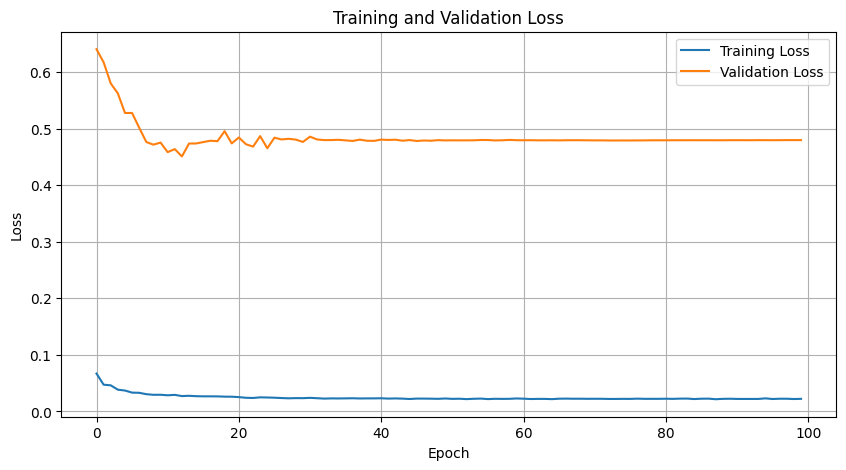

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.savefig("training_validation_loss.pdf", format="pdf")
plt.show()

In [ ]:
 #####################  test set  #####################

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CrimeLSTM(num_size, cat_size, hidden_size, embed_dim, num_layers, output_size, dropout)
model.load_state_dict(torch.load('best_lstm_model.pth', map_location=device))
model.eval()

CrimeLSTM(
  (embedding): Embedding(32, 16)
  (lstm): LSTM(28, 128, num_layers=3, batch_first=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
data = pd.read_csv("rnn_data_test.csv")
seq_len = 12
n_times = data["time_id"].nunique()
n_locations = data["location_id"].nunique()
location2idx = {location: i for i, location in enumerate(data["location_id"].unique())}
time2idx = {time: i for i, time in enumerate(data["time_id"].unique())}
data["location_idx"] = data["location_id"].map(location2idx)
data["time_idx"] = data["time_id"].map(time2idx)

features = [
    "crime_count",
    "crime_pct_change",
    "Year",
    "Month",
    "morning_rate",
    "evening_rate",
    "afternoon_rate",
    "night_rate",
    "num_days",
    "holiday_num",
    "sin_month",
    "cos_month",
]
n_features = len(features)
pivot_df = data.pivot(
    index="time_idx",
    columns="location_idx",
    values=features,
)
pivot_df = pivot_df.fillna(0)
train_size = int((len(pivot_df) - seq_len) - 12)
print(f"train_size: {train_size}")

from sklearn.preprocessing import MinMaxScaler

scaled_df = pivot_df.copy()
scaler = MinMaxScaler()
print(scaled_df.shape)
scaled_df[: train_size + seq_len] = scaler.fit_transform(
    scaled_df[: train_size + seq_len]
)
scaled_df[train_size + seq_len :] = scaler.transform(scaled_df[train_size + seq_len :])
scaled_df = pd.DataFrame(scaled_df, columns=pivot_df.columns)
scaled_df

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def scale_by_feature_type(pivot_df, train_size, seq_len):
    scaled_df = pivot_df.copy()
    feature_types = pivot_df.columns.get_level_values(0).unique()
    scaler_ls = []
    for feature in feature_types:
        feature_cols = [col for col in pivot_df.columns if col[0] == feature]
        scaler = MinMaxScaler()
        feature_data = pivot_df[feature_cols]
        train_data = feature_data.iloc[: train_size + seq_len]
        scaler.fit(train_data)
        scaled_df[feature_cols] = scaler.transform(feature_data)
        scaler_ls.append(scaler)
    return scaled_df, scaler_ls

scaled_df, scaler_ls = scale_by_feature_type(pivot_df, train_size, seq_len)


def create_sequences(feat_df, seq_length=12):
    X_seq = []
    y_vals = []
    loc_idx = []
    time_idx = []
    T = feat_df.shape[0]
    locations = feat_df.columns.get_level_values(1).unique()
    crime_feature = feat_df.columns.get_level_values(0)[
        0
    ] 
    for location in locations:
        location_data = feat_df.xs(location, axis=1, level=1)

        for i in range(T - seq_length):
            feature_window = location_data.iloc[
                i : i + seq_length
            ].values  # shape (seq_length, n_features)
            y_val = feat_df[(crime_feature, location)].iloc[i + seq_length]
            X_seq.append(feature_window)
            y_vals.append(y_val)
            loc_idx.append(location)
            time_idx.append(i)
    X_seq = np.array(X_seq)  # shape => (n_locations * n_times, seq_length, n_features)
    y_vals = np.array(y_vals)  # shape => (n_locations * n_times,)
    loc_idx = np.array(loc_idx)  # shape => (n_locations * n_times,)
    time_idx = np.array(time_idx)  # shape => (n_locations * n_times,)
    return X_seq, y_vals, loc_idx, time_idx


seq_length = 12
X_seq, y, loc_idx, time_idx = create_sequences(scaled_df, seq_length=seq_length)

print("X_seq shape:", X_seq.shape)  # (n_locations * n_times, seq_length, n_features)
print("y shape:", y.shape)  # (n_locations * n_times,)
print("loc_idx shape:", loc_idx.shape)  # (n_locations * n_times,)
print("time_idx shape:", time_idx.shape)  # (n_locations * n_times,)

train_mask = time_idx < train_size
test_mask = time_idx >= train_size

X_test = X_seq
y_test = y
loc_test = loc_idx
time_test = time_idx

print("Test shapes:", X_test.shape, y_test.shape, loc_test.shape, time_test.shape)

from torch.utils.data import Dataset, DataLoader


class CrimeDataset(Dataset):
    def __init__(self, X, y, loc_idx, time_idx):
        self.X = X  # n_sequences, seq_len, n_location
        self.y = y  # n_sequences, n_location
        self.loc_idx = loc_idx
        self.time_idx = time_idx

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = torch.tensor(self.X[idx], dtype=torch.float32)
        y = torch.tensor(self.y[idx], dtype=torch.float32)
        loc_idx = torch.tensor(self.loc_idx[idx], dtype=torch.long)
        time_idx = torch.tensor(self.time_idx[idx], dtype=torch.long)
        return X, y, loc_idx, time_idx
    
num_size = n_features
cat_size = n_locations
batch_size = 32
hidden_size = 128
num_layers = 3
embed_dim = 16
output_size = 1
num_epochs = 100
dropout = 0.5

test_dataset = CrimeDataset(X_test, y_test, loc_test, time_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_size: 48
(72, 372)
X_seq shape: (1860, 12, 12)
y shape: (1860,)
loc_idx shape: (1860,)
time_idx shape: (1860,)
Test shapes: (1860, 12, 12) (1860,) (1860,) (1860,)


In [42]:
def predictions(model, test_loader, n_locations, device, num_layers, hidden_size):
    result = np.zeros(
        (
            len(test_loader.dataset) // n_locations,
            n_locations,
            2,
        )
    )

    def get_result(result, loader):
        model.eval()
        with torch.no_grad():
            for i, (X_batch, y_batch, loc_batch, time_batch) in enumerate(loader):
                curr_batch_size = X_batch.shape[0]
                X_batch, y_batch, loc_batch = (
                    X_batch.to(device),
                    y_batch.to(device),
                    loc_batch.to(device),
                )
                h = torch.zeros(num_layers, curr_batch_size, hidden_size).to(device)
                c = torch.zeros(num_layers, curr_batch_size, hidden_size).to(device)
                score, (_, _) = model(X_batch, loc_batch, h, c)
                score = score.reshape(curr_batch_size)
                result[time_batch, loc_batch.cpu().numpy(), 0] = score.cpu().numpy()
                result[time_batch, loc_batch.cpu().numpy(), 1] = y_batch.cpu().numpy()

    get_result(result, test_loader)
    return result

In [44]:
result = predictions(model, test_loader, n_locations, device, num_layers, hidden_size)

In [46]:
result_unscaled = np.zeros(result.shape)
result_unscaled[:, :, 0] = scaler_ls[0].inverse_transform(result[:, :, 0])
result_unscaled[:, :, 1] = scaler_ls[0].inverse_transform(result[:, :, 1])
result_unscaled = np.round(result_unscaled).astype(int)

result_df = data.copy()
result_df["lstm_pred"] = np.nan
for i in range(len(result_unscaled)):
    for j in range(len(result_unscaled[i])):
        result_df.loc[
            (result_df["time_idx"] == i + seq_length)
            & (result_df["location_idx"] == j),
            "lstm_pred",
        ] = result_unscaled[i, j, 0]

result_df = result_df[result_df["time_idx"] > seq_length - 1]
result_df.to_csv("lstm_predictions.csv", index=False)